### Mini-LA Assignment 1: Classification and Prediction

**Authors**: Mina Choi, Nicolas Dussaillant

**Course**: HUDK4051 Learning Analytics: Process and Theory

### Introduction



As numerous college students over-enroll in courses at the beginning of the semester then choose to drop many courses that they have enrolled in, trying to predict final course enrollments and allocate resources are a common problem for most of the universities. However, since it would be very disadvantageous for students to not have this choice in the first few weeks of the semester, the schools are not willing to take away this “add and drop” period. Alternatively, many institutions are trying to predict which students are most likely to drop out of which courses using classification and prediction algorithms with the student and course data in their system.

As a result, the following work seeks to create a classifier to predict the drop out of courses in a certain college. The data was given as part of the assignment and contains information about students and courses for different years.

Across this work we conducted a literature review, data description, data cleaning and preparation, feature selection, and three algorithms: Random Forests (with and without bootstrap), Support Vector Classifier, and a type of Neural Networks. To train each algorithm the sample was divided into training and testing samples with a proportion of 80%-20%. After that for each training and testing set the accuracy, precision, recall, and F1 score were measured and compared.

### Literature review

  Similar to the topic for our classification and prediction assignment, Kabathova & Drlik (2021) examines multiple machine learning classifiers to predict student’s dropout in university courses. The purpose of this study is to accentuate the significance of data understanding and gathering, recognize the common circumstances that educational data researchers are in-limitations of the available or accessible datasets, and compare the performance of multiple classification algorithms in machine learning. In addition, Kabathova & Drlik (2021) proves that a limited set of features in a dataset can also predict students’ dropout with sufficient accuracy (77-93%) if the performance metrics are thoroughly and correspondingly examined.
  This study uses the following five categories of the course features: Accesses, Assignments, Tests, Exam, and Project as independent variables and applies logistic regression, decision tree, Naive Bayes, support vector machine, random forest, and neural network algorithms to evaluate which model would be the most accurate and suitable for predicting student dropout in virtual learning environments. The variables Access, Assignments, and Tests were finally selected as the most important factors since the prediction should be made as early as possible to have enough time for intervention. Based on the precision, recall, accuracy and F1 scores, the results showed that the best prediction technique was the random forest (RF) model with an overall accuracy of 93%, followed by logistic regression, support vector machine, and decision tree algorithms. 
  A few limitations of this study include scarcity of the dataset, the limiting number of independent variables or course activities, and lack of details in the form of suitable intervention. This study could be improved by having a larger dataset, including more course features or variables that may factor into student's dropout in virtual learning settings, and examining further into how other categories of course activities would have a similar influence on students’ engagement level and for which activities they can be exchanged in the intervention phase.

Kabathova, J., & Drlik, M. (2021). Towards predicting student’s dropout in university courses using different machine learning techniques. Applied Sciences, 11(7), 3130.

### Data preparation

In this part we import the data and adjust the format for some of the columns. The work will be handle using pandas.

Import libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

Import data in the proper format

In [2]:
#Lambda function to parse binary variables to 1 and 0.
parse_dich = lambda x : 1 if x == "yes" else (0 if x == "no" else -1)

#Some variables expressed as numbers will be treated as Strings because their numerical magnitude is not relevant
df = pd.read_csv("drop-out.csv",
                 dtype = {
                    "student_id" : str,
                    "course_id" : str,
                    "gender" : str,
                    "years" : int,
                    "courses_taken" : int,
                    "entrance_test_scoe" : float,
                    "enroll_date_time" : int
                 },
                 converters = {
                     "complete" : parse_dich,
                     "international" : parse_dich,
                     "online" : parse_dich,
                 })

### Data Description

In this section we check the data along with some descriptive statistics, to then select the features that will be used for the predictive algorithms.

In [3]:
# Check the format
display(df.head())

# Check some general data:
print("Number of Rows: " + str(len(df.index)))
print(f"Number of Different Students {df['student_id'].nunique()}")
print(f"Number of Different Courses {df['course_id'].nunique()}")
print("Courses completed:")
display(df['complete'].value_counts())
print("Internationals:")
display(df['international'].value_counts())
print("Online:")
display(df['online'].value_counts())

,student_id,years,entrance_test_score,courses_taken,complete,enroll_date_time,course_id,international,online,gender
0,172777,0,47.0,4,1,159227767,807728,0,0,1
1,172777,0,47.0,4,1,159227782,658434,0,0,1
2,172777,0,47.0,4,1,159227866,658463,0,0,1
3,172777,0,47.0,4,1,159227948,658498,0,0,1
4,175658,0,92.8,22,1,157446419,807728,0,0,1


Number of Rows: 5861
Number of Different Students 682
Number of Different Courses 35
Courses completed:


1    4137
0    1724
Name: complete, dtype: int64

Internationals:


0    4997
1     864
Name: international, dtype: int64

Online:


0    4478
1    1383
Name: online, dtype: int64

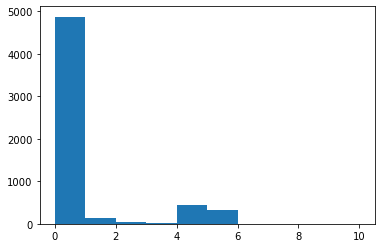

In [4]:
# Distribution of the years
plt.hist(df['years'])
plt.show()

In [5]:
# Check the range of enroll dates
print("Earliest date: ", date.fromtimestamp(min(df.enroll_date_time)))
print("Latest date: ", date.fromtimestamp(max(df.enroll_date_time)))

Earliest date:  1974-09-25
Latest date:  1975-02-13


The dates are missing something, but if we multiply them by 10 we get more credible values:

In [6]:
df.enroll_date_time = df.enroll_date_time * 10
print("Earliest date: ", date.fromtimestamp(min(df.enroll_date_time)))
print("Latest date: ", date.fromtimestamp(max(df.enroll_date_time)))

Earliest date:  2017-05-01
Latest date:  2021-03-07


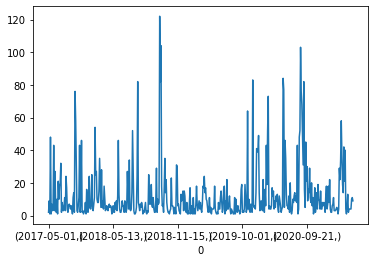

In [7]:
# Check the distibution of the dates
enroll_dates = pd.DataFrame([date.fromtimestamp(x) for x in df["enroll_date_time"]])
enroll_dates_count = enroll_dates.value_counts().sort_index()
enroll_dates_count.plot()
plt.show()

Check the distribution per month:

<AxesSubplot:xlabel='enroll_month', ylabel='count'>

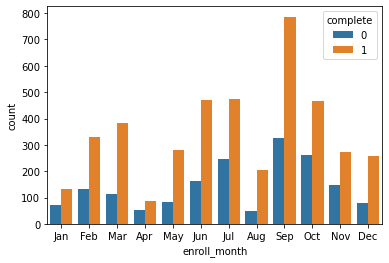

In [8]:
df["enroll_month"] = [date.fromtimestamp(x).strftime('%b') for x in df['enroll_date_time']]
sns.countplot(x = "enroll_month", data = df, hue = "complete", 
              order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

In [9]:
#Check the courses enrolled and completed quantities
pd.pivot_table(df[["student_id", "course_id", "complete"]], values=["student_id"], index=["course_id"], columns=["complete"], aggfunc='count')

student_id       
complete           0      1
course_id                  
658434         465.0  407.0
658438         189.0  253.0
658439          66.0  125.0
658440          27.0   18.0
658441          24.0   38.0
658442           9.0   12.0
658443           6.0    6.0
658444           4.0    2.0
658445           1.0    1.0
658450          18.0   22.0
658463         315.0  447.0
658464         128.0  197.0
658465          41.0   41.0
658466          16.0   22.0
658467          28.0   23.0
658468           7.0    9.0
658469           NaN    1.0
658470          65.0   77.0
658472           2.0    3.0
658481           4.0    4.0
658493           2.0    5.0
658494          29.0   80.0
658495          74.0  158.0
658496           1.0   12.0
658497           9.0   39.0
658498         141.0  547.0
658499           5.0   23.0
658500           1.0    3.0
658514          23.0   48.0
807717           7.0  456.0
807728          14.0  418.0
807754           2.0  211.0
807755           1.0   98.0
807757           NaN   96.0
807758           NaN  235.0

In [10]:
# Check one student with multiple years:
display(df[df.student_id == "175658"])

,student_id,years,entrance_test_score,courses_taken,complete,enroll_date_time,course_id,international,online,gender,enroll_month
4,175658,0,92.8,22,1,1574464190,807728,0,0,1,Nov
5,175658,5,92.8,22,0,1574464240,658434,0,0,1,Nov
6,175658,4,92.8,22,0,1574464410,658463,0,0,1,Nov
7,175658,4,92.8,22,0,1574464490,658498,0,0,1,Nov
8,175658,0,92.8,22,1,1574464580,807754,0,0,1,Nov
9,175658,5,92.8,22,0,1574464630,658438,0,0,1,Nov
10,175658,4,92.8,22,0,1574464700,658464,0,0,1,Nov
11,175658,4,92.8,22,0,1574464760,658495,0,0,1,Nov
12,175658,0,92.8,22,1,1574464840,807755,0,0,1,Nov
13,175658,5,92.8,22,0,1574464910,658439,0,0,1,Nov


For different years the number of courses enrolled is the same. In this case, the student has different rows for different years, but all the courses_taken are the same regardless the year.

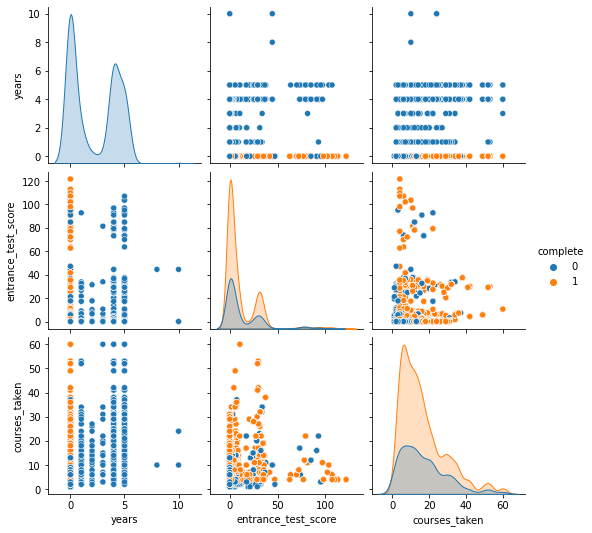

In [11]:
# Check relations between continuos variables and the course completed
sns.pairplot(df, hue = "complete", vars = ["years", "entrance_test_score", "courses_taken"])

In [12]:
# Check the completeness per year
pd.pivot_table(df[["student_id", "years", "complete"]], values=["student_id"], index=["years"], columns=["complete"], aggfunc='count')

student_id        
complete          0       1
years                      
0             734.0  4137.0
1             140.0     NaN
2              41.0     NaN
3              29.0     NaN
4             453.0     NaN
5             323.0     NaN
8               1.0     NaN
10              3.0     NaN

### Feature Selection
Based on the analyses above, we will select, modify, filter and create the features for the algorithms.

In [13]:
df_analysis = df.copy()

**Course**

The course is important to determine if a student will dropout, so we compute it as dummy variables:

In [14]:
df_analysis = pd.concat([df, pd.get_dummies(df_analysis['course_id'], prefix="C")], axis=1)

**Years:**

As seen in the last histogram from the last section, every student not from first year is marked as not completed. Because that would mean that predicting for students not in year 0 would be deterministic, we will drop all of those cases.

In [15]:
df_analysis.drop(df_analysis[df_analysis.years != 0].index, inplace=True)

**Courses taken**

Since, as we saw before, the courses are cumulative even for different years, we will readjust that variable as an aggregation for courses taken in year 0 by each student. That way that variable will make more sense.

In [16]:
df_aux = df_analysis[["student_id", "course_id"]].groupby(by="student_id").count()
df_analysis = df_analysis.merge(df_aux, on = "student_id", how = "left", suffixes = ("", "_count"))

**Test Score**

Since a lot of students have 0 in their entrance test score, we assume that those students didn't take the test. To acknowledge that, we create a binary variable that takes the impact of whether the student has a score or not. The test score in its original scale will remain usable and it will represent the interaction between those columns.

In [17]:
df_analysis["has_test"] = (df_analysis["entrance_test_score"] > 0) * 1

**Enroll date**

As seen in the previous section, it could be a better idea to use months instead the whole date. We will compute this as dummy variables to avoid the numerical value of months.

In [18]:
df_analysis = pd.concat([df_analysis, pd.get_dummies(df_analysis['enroll_month'])], axis=1)

**Gender**

Since this dataset includes more than 2 gender, we compute gender as dummy variables.

In [19]:
df_analysis = pd.concat([df_analysis, pd.get_dummies(df_analysis['gender'], prefix="gender")], axis=1)

**Online** and **International**

Bothe variables remain the same.

**Last preparation**

After the feature selection, we create the dataframe for the further predictions. We select just the columns with the features we will use and we keep the rows in the format as unique combinations of student-course.

In [20]:
df_algorithms = df_analysis.drop(columns = ["student_id", "courses_taken", 
                                            "enroll_date_time", "course_id", "years",
                                            "gender", "enroll_month"])
display(df_algorithms.columns)

X = df_algorithms.drop(columns=["complete"])
y = df_algorithms.complete

Index(['entrance_test_score', 'complete', 'international', 'online',
       'C_658434', 'C_658438', 'C_658439', 'C_658440', 'C_658441', 'C_658442',
       'C_658443', 'C_658444', 'C_658445', 'C_658450', 'C_658463', 'C_658464',
       'C_658465', 'C_658466', 'C_658467', 'C_658468', 'C_658469', 'C_658470',
       'C_658472', 'C_658481', 'C_658493', 'C_658494', 'C_658495', 'C_658496',
       'C_658497', 'C_658498', 'C_658499', 'C_658500', 'C_658514', 'C_807717',
       'C_807728', 'C_807754', 'C_807755', 'C_807757', 'C_807758',
       'course_id_count', 'has_test', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul',
       'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'gender_1', 'gender_2',
       'gender_3', 'gender_4', 'gender_5'],
      dtype='object')

## Algorithms

In this section we evaluate the different algorithms. For that, we split the sample into training and testing samples, in a 80-20 proportion.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4051)

We will evaluate for each algorithm its accuracy, recall, precision and f1 score. For that we create a dataframe and a function to fill it, so we will have a summary for the discussion.

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report

prediction_results = pd.DataFrame(columns = ['algorithm', 'accuracy_train', 'precision_train', 'recall_train', 'f1_train',
                                                          'accuracy_test', 'precision_test', 'recall_test', 'f1_test'])

def evaluate_alg(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    row = [name, accuracy_train, precision_train, recall_train, f1_train,
           accuracy_test, precision_test, recall_test, f1_test]
    
    # Add row to the results df
    global prediction_results

    prediction_results.loc[-1] = row
    prediction_results.index = prediction_results.index + 1
    prediction_results = prediction_results.sort_index()

    print("Training set:")
    print(classification_report(y_test, y_test_pred))

    print("Testing set:")
    print(classification_report(y_test, y_test_pred))

    return confusion_matrix(y_test, y_test_pred)


### First algorithm: *Random Forest*

In [23]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, bootstrap = False, random_state = 4051)
forest_bootstrap = RandomForestClassifier(n_estimators = 100, bootstrap = True, random_state = 4051)

evaluate_alg("Random Forest", forest, X_train, y_train, X_test, y_test)
evaluate_alg("Random Forest (bootstrap)", forest_bootstrap, X_train, y_train, X_test, y_test)

Training set:
              precision    recall  f1-score   support

           0       0.40      0.28      0.33       144
           1       0.88      0.93      0.90       831

    accuracy                           0.83       975
   macro avg       0.64      0.60      0.62       975
weighted avg       0.81      0.83      0.82       975

Testing set:
              precision    recall  f1-score   support

           0       0.40      0.28      0.33       144
           1       0.88      0.93      0.90       831

    accuracy                           0.83       975
   macro avg       0.64      0.60      0.62       975
weighted avg       0.81      0.83      0.82       975

Training set:
              precision    recall  f1-score   support

           0       0.48      0.26      0.33       144
           1       0.88      0.95      0.91       831

    accuracy                           0.85       975
   macro avg       0.68      0.60      0.62       975
weighted avg       0.82      0.85

array([[ 37, 107],
       [ 40, 791]])

### Second algorithm: *Support Vector Machine*

In [24]:
from sklearn.svm import SVC
svc = SVC(random_state = 4051)

evaluate_alg("Support Vector Classifier", svc, X_train, y_train, X_test, y_test)

Training set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       144
           1       0.85      1.00      0.92       831

    accuracy                           0.85       975
   macro avg       0.43      0.50      0.46       975
weighted avg       0.73      0.85      0.78       975

Testing set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       144
           1       0.85      1.00      0.92       831

    accuracy                           0.85       975
   macro avg       0.43      0.50      0.46       975
weighted avg       0.73      0.85      0.78       975



/Users/ndussaillant/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndussaillant/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndussaillant/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

array([[  0, 144],
       [  0, 831]])

### Third algorithm: *Neural Network*

In [25]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state = 4051, max_iter = 1000)

evaluate_alg("Neural Network", mlp, X_train, y_train, X_test, y_test)

Training set:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33       144
           1       0.88      0.96      0.92       831

    accuracy                           0.85       975
   macro avg       0.69      0.60      0.63       975
weighted avg       0.82      0.85      0.83       975

Testing set:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33       144
           1       0.88      0.96      0.92       831

    accuracy                           0.85       975
   macro avg       0.69      0.60      0.63       975
weighted avg       0.82      0.85      0.83       975



array([[ 36, 108],
       [ 36, 795]])

### Performance Summary

In [26]:
display(prediction_results)

,algorithm,accuracy_train,precision_train,recall_train,f1_train,accuracy_test,precision_test,recall_test,f1_test
0,Neural Network,0.930698,0.930760,0.992136,0.960469,0.852308,0.880399,0.956679,0.916955
1,Support Vector Classifier,0.848563,0.848563,1.000000,0.918078,0.852308,0.852308,1.000000,0.920266
2,Random Forest (bootstrap),0.983060,0.983871,0.996370,0.990081,0.849231,0.880846,0.951865,0.914980
3,Random Forest,0.983060,0.993902,0.986086,0.989979,0.832821,0.881279,0.929001,0.904511


### Discussion

Based on the above results, the best performance model for our analysis is the neural network algorithm, with scores in accuracy 85%, precision 88%, recall 96% and f1 92%. On the other hand, the SVC or support vector classifier displayed the worst performance since it is a linear predictor. Our assumption for this result in low accuracy from the SVC model is due to the fact that most of the variables used here are dichotomous. Additionally we can observe that the Random Forest created using Bootstrap performs better than without it; which corresponds with hypothesis that say Bootstrap helps to avoid overfitting.

A recursive feature selection was tried with a Logistic Regression and a Decision Tree Classifier seeking to optimize the accuracy score. However, due to the large number of binary variables instead of continuous, logistic regression didn't give a good result, and the decision tree maintained a high percentage of all the variables, so discarding them didn't make too much sense.

### Conclusion

After this work, it was possible to create a good classifier to predict drop out of courses for a university. Variables such as course_id, month of the enrollment, being online or being international, among others, were used to predict and presented a good performance.

The best algorithm evaluated was a neural network based on a Multi-layer Perceptron classifier, using its default parameters from ScikitLearn package but a maximum iterations of 1,000 instead of 200. Further works could include other types of neural networks, the creation of more variables, or including K-Fold validation.